In [1]:
%load_ext autoreload
%autoreload 2

import particle as pt
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mplhep
from scipy.stats import norm
from scipy.optimize import curve_fit
import matplotlib.mlab as mlab
import time
from matplotlib.colors import LogNorm
mplhep.style.use(mplhep.style.ROOT)
from pprint import pprint
from tqdm import tqdm
import polars as pl
import sys
import os
# using getlogin() returning username
user_name = os.getlogin()

sys.path.append(f'/home/{user_name}/Documents/Atmos_Pandora/apc_atmo_repo/Anatree/')
from anatree_class import Anatree


plt.rcParams.update({'font.size': 16,
                     'grid.linestyle': '--',
                     'axes.grid': True,
                     'figure.autolayout': True,
                     'figure.figsize': [14,6]
                     })

anatree:Anatree

In [2]:
anatree = Anatree("/home/henrique/Documents/Atmos_Pandora/data/atm_50k_hd_AV_2.5_random/anatree_hd_AV_2dot5_random_sum_300k.root", entry_start=0, entry_stop=1000, load_data=False)
anatree.tree:uproot.TTree

In [9]:
# geant = anatree.geant
nu = anatree.nu
shw = anatree.reco_showers
tracks = anatree.reco_tracks
showers = anatree.reco_showers
# merged = anatree.get_full_reco_tracks()

In [8]:
# anatree.write_polars_parquet('../../../../../data/atm_50k_hd_AV_2.5_random/parquet', batch_size=50000, max_events=50000, exclude=[''])

In [4]:
# anatree.read_parquet('../../../../../data/atm_50k_hd_AV_2.5_random/parquet',batches=-1, types=['nu','reco_tracks','reco_showers'])#, n_rows=100)

import glob

queries = []
for file in glob.glob("../../../../../data/atm_50k_hd_AV_2.5_random/parquet/geant_*.parquet"):
    print(file)
    q = pl.scan_parquet(file)
    queries.append(q)

dataframes = pl.collect_all(queries)


../../../../../data/atm_50k_hd_AV_2.5_random/parquet/geant_3.parquet
../../../../../data/atm_50k_hd_AV_2.5_random/parquet/geant_5.parquet
../../../../../data/atm_50k_hd_AV_2.5_random/parquet/geant_2.parquet
../../../../../data/atm_50k_hd_AV_2.5_random/parquet/geant_4.parquet
../../../../../data/atm_50k_hd_AV_2.5_random/parquet/geant_1.parquet
../../../../../data/atm_50k_hd_AV_2.5_random/parquet/geant_0.parquet


In [5]:
df = dataframes[0]
for i, dfnew in enumerate(dataframes[1:]):
    df = pl.concat([df,dfnew], rechunk=False)
     


In [7]:
anatree.read_parquet('../../../../../data/atm_50k_hd_AV_2.5_random/parquet',batches=-1, types=['nu','reco_tracks','reco_showers'])#, n_rows=100)
nu = anatree.nu

# q = (
   
# )

Reading nu files... 6/6
Reading reco_tracks files... 6/6
Reading reco_showers files... 6/6


In [10]:
q = (
    tracks.join(df, left_on=["subrun", "event", "trkg4id_pandoraTrack"], right_on=["subrun", "event", "TrackId_geant"], how="left").lazy()
)

In [13]:
import particle 
merged = q.collect()
pdg_list = merged.with_columns(
    pl.col('pdg_geant').abs()
).groupby('pdg_geant').agg(
    counts = pl.col('pdg_geant').count(),
    pdgs_name = pl.col('pdg_geant').first().apply(particle.Particle.from_pdgid),
    as_mothers = pl.col('Mother_geant').filter(pl.col('Mother_geant') == 0).count()
).sort('pdg_geant')


pl.Config.set_tbl_rows(100)
print(pdg_list)



shape: (60, 4)
┌────────────┬────────┬───────────┬────────────┐
│ pdg_geant  ┆ counts ┆ pdgs_name ┆ as_mothers │
│ ---        ┆ ---    ┆ ---       ┆ ---        │
│ i32        ┆ u32    ┆ object    ┆ u32        │
╞════════════╪════════╪═══════════╪════════════╡
│ 11         ┆ 134601 ┆ e-        ┆ 114161     │
│ 13         ┆ 92019  ┆ mu-       ┆ 86895      │
│ 22         ┆ 193738 ┆ gamma     ┆ 6390       │
│ 211        ┆ 118003 ┆ pi+       ┆ 64736      │
│ 321        ┆ 3325   ┆ K+        ┆ 1747       │
│ 2212       ┆ 308389 ┆ p         ┆ 172398     │
│ 3112       ┆ 53     ┆ Sigma-    ┆ 50         │
│ 3222       ┆ 18     ┆ Sigma+    ┆ 16         │
│ 1000010020 ┆ 2885   ┆ D2        ┆ 0          │
│ 1000010030 ┆ 201    ┆ T3        ┆ 0          │
│ 1000010040 ┆ 17     ┆ H4        ┆ 0          │
│ 1000020030 ┆ 40     ┆ He3       ┆ 0          │
│ 1000020040 ┆ 114    ┆ He4       ┆ 0          │
│ 1000020060 ┆ 1      ┆ He6       ┆ 0          │
│ 1000030060 ┆ 3      ┆ Li6       ┆ 0          │
│ 100

In [5]:
tracks = pl.scan_parquet('../../../../../data/atm_50k_hd_AV_2.5_random/parquet/reco_tracks_*.parquet')
merged = tracks.join(df, left_on=["subrun", "event", "trkg4id_pandoraTrack"], right_on=["subrun", "event", "TrackId_geant"], how="left")
merged
merged.collect()

<LazyFrame [148 cols, {"subrun": Int32 … "processname_geant": Utf8}] at 0x7F85C45FE380>

In [8]:
# df = dataframes[0]
df = dataframes
del q

# q = (
#     pl.concat([df[0],df[1]])
# ).lazy()
# for i, dfa in enumerate(dataframes[1:]):
#     print(i)
#     df = pl.concat([df, dfa])
#     del dataframes[1]

# for i, dfa in enumerate(dataframes[1:]):
#     df = pl.concat([df,dfa])
#     del dataframes[i]

In [9]:
df.groupby([ 'subrun', 'event' ]).agg().sort('subrun')

subrun,event
i32,i32
3,2
3,19
3,20
3,13
3,16
3,7
3,11
3,14
3,9


In [57]:
df = anatree.nu
df.sort(['subrun','event']).groupby('subrun').agg(
    pl.col('event').sum()
).filter(pl.col('event').is_unique())


subrun,event
i32,i32


In [19]:
anatree

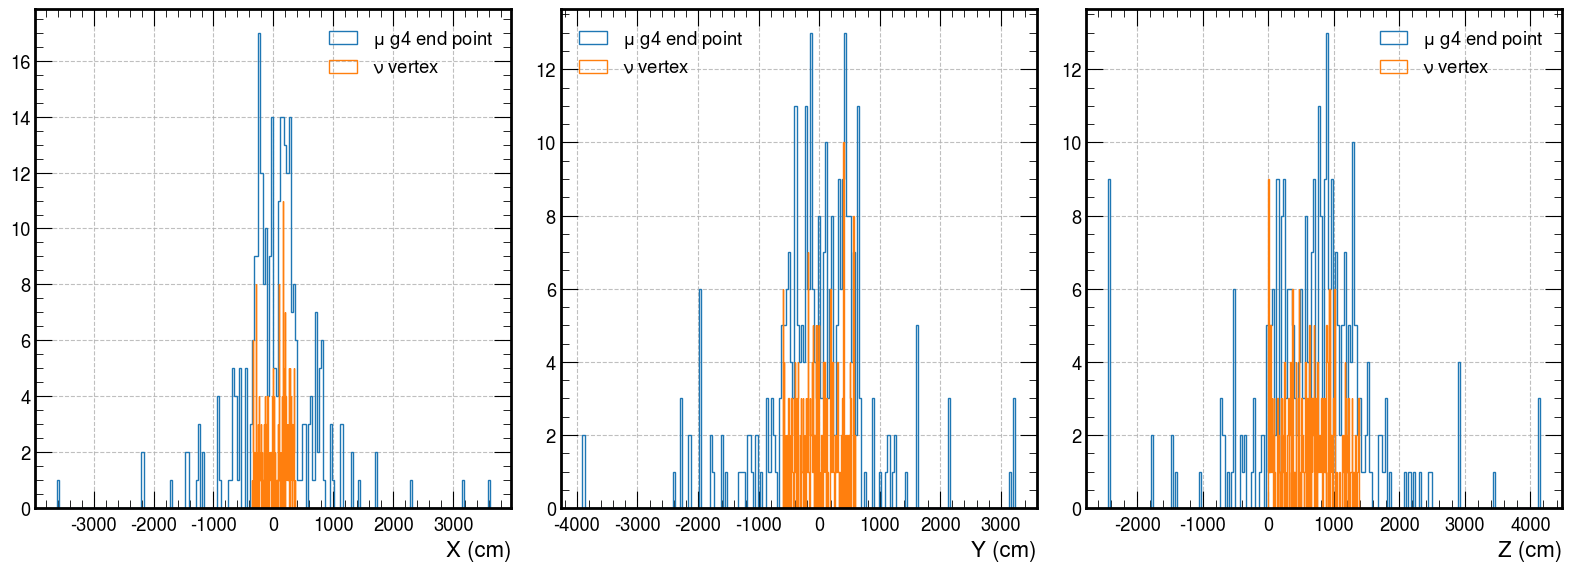

In [9]:
pl.Config.set_tbl_cols(20)
test = merged.filter(
    (pl.col('Mother_geant')==0) & (pl.col('pdg_geant').abs() == 13)
)
is_duplicated

def make_plots(ax:plt.Axes, coord:str):
    ax.hist(test[f'EndPoint{coord}_geant'], bins = 200, histtype='step', label=rf'$\mu$ g4 end point')
    ax.hist(test[f'nuvtx{coord}'], bins = 200, histtype='step', label=rf'$\nu$ vertex')
    ax.set_xlabel(f'{coord.capitalize()} (cm)')
    ax.legend()

fig, axs = plt.subplots(1,3,figsize=(16,6))
make_plots(axs[0], 'x')
make_plots(axs[1], 'y')
make_plots(axs[2], 'z')

### Checking muons that scaped the TPC


In [33]:
# xlim = nu['nuvtxx'].abs().max()
# ylim = nu['nuvtxy'].abs().max()
# zmin = nu['nuvtxz'].min()
# zmax = nu['nuvtxz'].max()
xlim = 363.376 - 20
ylim = 607.829 - 20
zmin = -0.87625 + 20
zmax = 1393.46 - 20
print(f'{xlim} {ylim} {zmin} {zmax}')

# merged = geant.join(tracks, left_on=["subrun", "event", "TrackId_geant"], right_on=["subrun", "event", "trkg4id_pandoraTrack"], how="inner")

out_siders = test
out_siders = out_siders.groupby(["subrun", "event"]).agg(
    pl.all().sort_by('trklen_pandoraTrack').last()
)
out_siders.sort([ 'subrun','event' ])
out_siders = out_siders.filter(
    # ~(pl.col('EndPointx_geant').abs() < xlim) | ~(pl.col('EndPointy_geant').abs() < ylim) | ~( pl.col('EndPointz_geant') > zmin ) & ( pl.col('EndPointz_geant') < zmax )
    ~(pl.col('trkendx_pandoraTrack').abs() < xlim) | ~(pl.col('trkendy_pandoraTrack').abs() < ylim) | ~(( pl.col('trkendz_pandoraTrack') > zmin ) & ( pl.col('trkendz_pandoraTrack') < zmax ))
)

out_siders.sort('subrun').head(20)
out_siders.filter(
    True
    # pl.col('trkhasPFParticle_pandoraTrack') == 0
).sort('subrun')

343.376 587.829 19.12375 1373.46


subrun,event,trkId_pandoraTrack,trkncosmictags_tagger_pandoraTrack,trkcosmicscore_tagger_pandoraTrack,trkcosmictype_tagger_pandoraTrack,trkncosmictags_containmenttagger_pandoraTrack,trkcosmicscore_containmenttagger_pandoraTrack,trkcosmictype_containmenttagger_pandoraTrack,trkncosmictags_flashmatch_pandoraTrack,…,nuvtxy_truth,nuvtxz_truth,enu_truth,nu_dcosx_truth,nu_dcosy_truth,nu_dcosz_truth,mode_truth,nuvtxx,nuvtxy,nuvtxz
i32,i32,i16,i16,f32,i16,i16,f32,i16,i16,…,f32,f32,f32,f32,f32,f32,i32,f32,f32,f32
0,9,0,-9999,-99999.0,-9999,-9999,-99999.0,-9999,-9999,…,-603.170349,1222.501587,5.01884,0.29367,0.576258,-0.762688,1,4.910364,-576.209412,1185.788208
0,15,0,-9999,-99999.0,-9999,-9999,-99999.0,-9999,-9999,…,-598.956543,1087.422363,1.03482,-0.923,-0.017455,0.384419,0,-361.977875,-598.497009,1087.157104
10,14,0,-9999,-99999.0,-9999,-9999,-99999.0,-9999,-9999,…,63.573792,621.285828,2.21251,0.715911,-0.684972,0.135245,1,-204.345673,63.951851,621.22644
11,15,0,-9999,-99999.0,-9999,-9999,-99999.0,-9999,-9999,…,49.704525,688.733154,0.405833,0.789169,-0.490818,0.369215,0,-346.071655,50.34988,689.199585
11,6,1,-9999,-99999.0,-9999,-9999,-99999.0,-9999,-9999,…,-359.880859,322.883514,15.851901,-0.16867,0.825554,-0.53853,2,-53.92746,-360.036072,323.074799
11,11,0,-9999,-99999.0,-9999,-9999,-99999.0,-9999,-9999,…,416.489319,945.806702,4.240087,0.130113,0.983005,0.129508,0,115.515053,469.275696,945.338318
11,12,1,-9999,-99999.0,-9999,-9999,-99999.0,-9999,-9999,…,581.394836,865.721985,0.992193,-0.355214,0.798963,-0.485269,10,-341.347351,581.938477,865.334534
12,9,0,-9999,-99999.0,-9999,-9999,-99999.0,-9999,-9999,…,-164.620117,1006.977234,0.540579,-0.0025,0.999992,0.003222,0,304.792572,-165.077835,1006.753845
12,1,0,-9999,-99999.0,-9999,-9999,-99999.0,-9999,-9999,…,73.767838,681.824829,1.419408,-0.71893,0.694228,0.034549,0,-119.341461,74.19841,681.829834


In [30]:
tmp = out_siders.select(
    pl.col('subrun'),
    pl.col('event'),
    pl.col('Eng_geant'),
    pl.col('EndPointx_geant'),
    pl.col('EndPointy_geant'),
    pl.col('EndPointz_geant'),
    # pl.col('trkg4id_pandoraTrack'),
    pl.col('trklen_pandoraTrack'),
    # pl.col('trkstartx_pandoraTrack'),
    # pl.col('trkstarty_pandoraTrack'),
    # pl.col('trkstartz_pandoraTrack'),
    pl.col('trkendx_pandoraTrack'),
    pl.col('trkendy_pandoraTrack'),
    pl.col('trkendz_pandoraTrack'),
    pl.col('trkPFParticleID_pandoraTrack')
).filter(
    True
    # (pl.col('event')==9) & (pl.col('subrun')==0)
).sort('subrun')
tmp.head(15)


# tracks.select(
#     pl.col('subrun'),
#     pl.col('event'),
#     pl.col('trkstartx_pandoraTrack'),
#     pl.col('trkstarty_pandoraTrack'),
#     pl.col('trkstartz_pandoraTrack'),
#     pl.col('trkendx_pandoraTrack'),
#     pl.col('trkendy_pandoraTrack'),
#     pl.col('trkendz_pandoraTrack')
# ).filter(
#     (pl.col('event')==9) & (pl.col('subrun')==0)
# )

subrun,event,Eng_geant,EndPointx_geant,EndPointy_geant,EndPointz_geant,trklen_pandoraTrack,trkendx_pandoraTrack,trkendy_pandoraTrack,trkendz_pandoraTrack,trkPFParticleID_pandoraTrack
i32,i32,f32,f32,f32,f32,f32,f32,f32,f32,i16
0,9,4.463607,319.632996,328.466949,-221.026978,1443.608398,278.704956,199.624405,0.566093,0
0,15,0.466599,-237.972977,-619.322205,1169.43042,6.229081,-357.230743,-599.958679,1090.517456,0
10,14,1.556513,359.131927,-202.678391,544.666382,627.267212,358.39151,-202.379211,545.59082,0
11,15,0.296703,-352.695496,115.619522,665.867371,69.066956,-352.262054,116.442406,665.966309,0
11,6,9.670719,-238.762833,2055.427002,-1168.952148,559.243835,-88.492531,140.474487,0.79487,1
11,11,1.824093,-421.627899,1174.778687,1253.624512,234.858459,-43.888275,599.959656,1018.060059,0
11,12,0.40929,-246.269424,725.797791,1063.62854,26.026775,-333.985077,600.271057,882.068909,1
12,9,0.471207,614.429016,90.060417,835.843872,84.556,362.397949,-110.057915,977.718506,0
12,1,1.189455,-356.289948,430.833679,855.931396,492.789276,-355.986877,454.564758,838.870972,0


In [46]:
subsample = merged.select(
    pl.col(["subrun", "event"]),
    pl.col("pdg_geant"),
    pl.col("^trk.*$"),
).select(
    # pl.all()
    pl.exclude("^*cosmic.*$")
)
# merged['trkg4id_pandoraTrack']
# sample_with_PFP = subsample.filter(

#     pl.col("trkhasPFParticle_pandoraTrack")!=0
# )
# sample_without_PFP = subsample.filter(
#     pl.col("trkhasPFParticle_pandoraTrack")==0
# )

# subsample.groupby([ 'subrun' , 'event']).agg(
#     pl.all()
# ).sort(['subrun','event'])

# sample_without_PFP.groupby([ 'subrun' , 'event']).agg(
#     pl.all()
# ).sort(['subrun','event'])

# sample_without_PFP.groupby('subrun').agg(
#     pl.all()
# )

trkId_pandoraTrack,trkke_pandoraTrack_x,trkke_pandoraTrack_y,trkke_pandoraTrack_z,trkrange_pandoraTrack_x,trkrange_pandoraTrack_y,trkrange_pandoraTrack_z,trkidtruth_pandoraTrack_x,trkidtruth_pandoraTrack_y,trkidtruth_pandoraTrack_z,…,trkpidchipi_pandoraTrack_z,trkpidchimu_pandoraTrack_x,trkpidchimu_pandoraTrack_y,trkpidchimu_pandoraTrack_z,trkpidpida_pandoraTrack_x,trkpidpida_pandoraTrack_y,trkpidpida_pandoraTrack_z,trkpidbestplane_pandoraTrack,trkhasPFParticle_pandoraTrack,trkPFParticleID_pandoraTrack
i16,f32,f32,f32,f32,f32,f32,i32,i32,i32,…,f32,f32,f32,f32,f32,f32,f32,i16,i16,i16
0,1476.505859,1362.933228,1683.381348,798.527405,797.377136,798.670837,1,1,1,…,2.353055,4.277405,30.71287,2.46693,8.585032,2.21278,8.214401,0,1,0
0,1.2417e9,2.1737e6,2.6077276e7,363.065247,355.107483,253.958633,2,2,2,…,34.401455,50.068401,8.917578,25.362474,0.87089,5.390366,4.357722,0,0,-1
2,136.023407,233.759064,220.873581,109.349487,123.521263,124.099213,7,7,7,…,18.108091,6.373022,8.151433,10.528322,6.415412,5.540125,5.591452,2,1,2
1,843.119385,742.362793,1084.849487,402.720062,404.477386,467.400696,1,1,1,…,11.312902,13.737896,40.190624,6.873935,4.988409,1.497825,6.154869,2,1,1
1,876.27179,1736.10083,4355.391113,278.079865,384.670319,449.971161,2181,2181,2181,…,-99999.0,23.059032,9.551797,-99999.0,1.631056,3.662461,-99999.0,1,0,-1
3,339.400024,142.811691,228.884262,188.72641,158.234299,178.806488,1107,1107,1107,…,34.323151,24.554359,21.477213,21.843901,1.493873,2.002241,1.983243,0,0,-1
0,1377.168457,1545.251221,1317.904053,589.975159,637.443665,565.187805,1,1,1,…,-99999.0,12.546865,11.287549,-99999.0,6.214195,5.403179,-99999.0,1,0,-1
0,58281.710938,137399.453125,5.0195696e8,553.821777,620.588684,588.565857,20313,20313,20313,…,-99999.0,37.178082,0.090078,-99999.0,0.673369,8.468921,-99999.0,1,0,-1
0,2062.045898,1948.026733,2165.294678,905.197266,905.892517,906.51886,1,1,1,…,10.471569,6.346371,29.586645,5.991809,6.253466,1.950269,6.322785,0,1,0


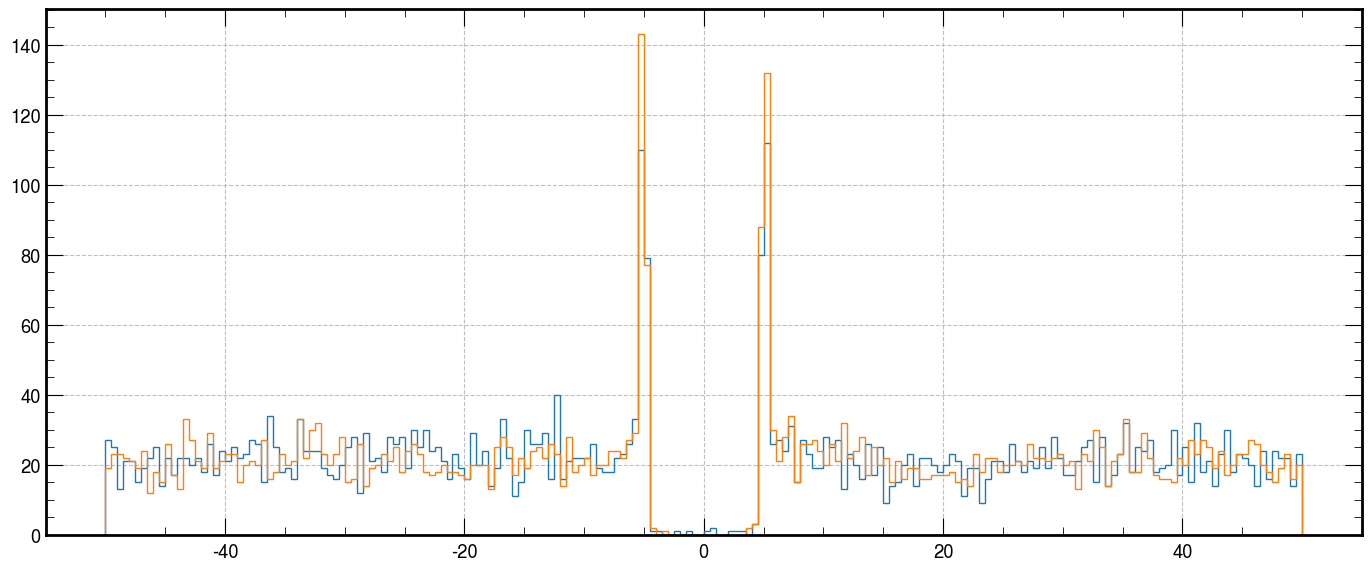

In [47]:
plt.hist(tracks['trkendx_pandoraTrack'], bins=200, range=(-50,50), histtype='step');
plt.hist(tracks['trkstartx_pandoraTrack'], bins=200, range=(-50,50), histtype='step');
# pl.Config.set_tbl_cols(100)
tracks.filter(
    (pl.col('trkendx_pandoraTrack')*pl.col('trkstartx_pandoraTrack') < 0) 
).select(
    pl.col('^trk.*$')
).select(
    pl.exclude("^*cosmic.*$")
)



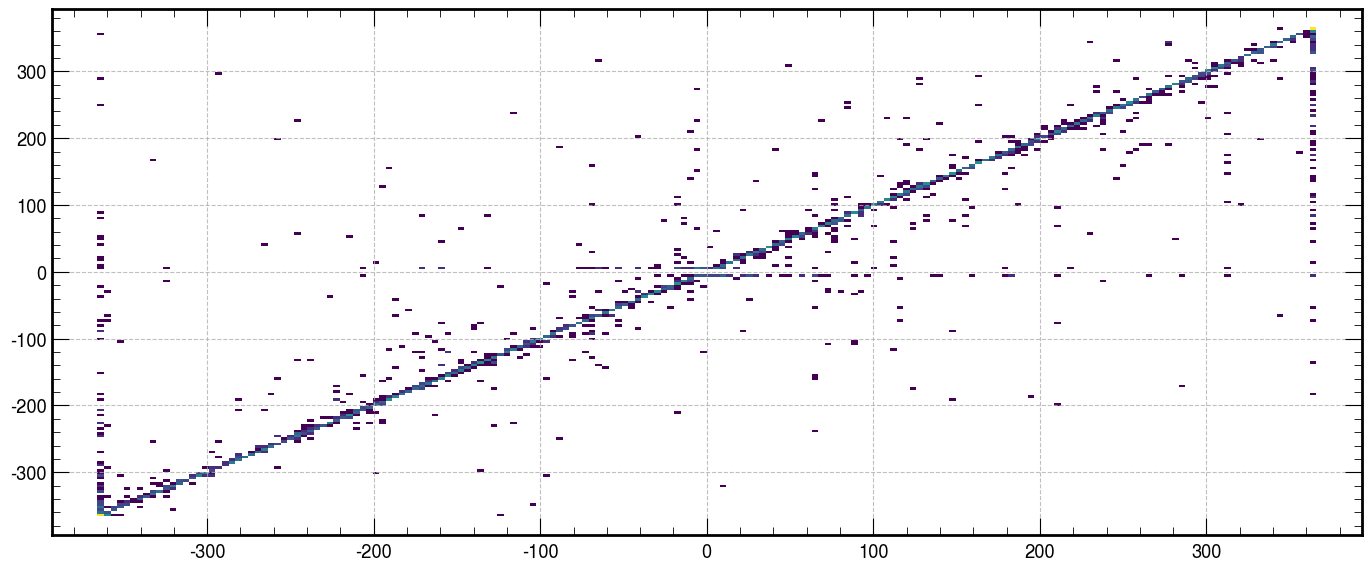

In [39]:

tmp = merged.filter(
    (pl.col('pdg_geant').abs() == 13) & (pl.col('Mother_geant')== 0),
).filter(
    ( pl.col('trkhasPFParticle_pandoraTrack') == 1 )

)
plotlim = xlim+50
plt.hist2d(tmp['EndPointx_drifted_geant'], tmp['trkendx_pandoraTrack'], bins=(200,200), range=((-plotlim,plotlim),(-plotlim,plotlim)), norm=LogNorm());


In [86]:
anatree.tree["EndE_drifted_geant"]
cols = [key for key in anatree.tree.keys() if 'trk' in key] 
# cols.remove("no_primaries_geant")
# cols.remove("geant_list_size_geant")
# cols.remove("geant_list_size_in_tpcAV_geant")
cols
test = [col.name for col in tracks.mean().select(pl.all().max() < -99) if col.item()]

exclusion_list = ['cosmic', 'T0', 'momms', 'pidmva', 'evtxid']  #all this are empty
cols = [x for x in cols if any(exclusion_item not in x for exclusion_item in exclusion_list)]
cols
# cols = set(cols)
# test = set(test)
cols

# test
# tracks.mean().select(
#     pl.all().max() > 0
# )

# [col.item() for col in tracks.select(pl.all().max()<0)]

['trkId_pandoraTrack',
 'trkncosmictags_tagger_pandoraTrack',
 'trkcosmicscore_tagger_pandoraTrack',
 'trkcosmictype_tagger_pandoraTrack',
 'trkncosmictags_containmenttagger_pandoraTrack',
 'trkcosmicscore_containmenttagger_pandoraTrack',
 'trkcosmictype_containmenttagger_pandoraTrack',
 'trkncosmictags_flashmatch_pandoraTrack',
 'trkcosmicscore_flashmatch_pandoraTrack',
 'trkcosmictype_flashmatch_pandoraTrack',
 'trkke_pandoraTrack',
 'trkrange_pandoraTrack',
 'trkidtruth_pandoraTrack',
 'trkorigin_pandoraTrack',
 'trkpdgtruth_pandoraTrack',
 'trkefftruth_pandoraTrack',
 'trkpurtruth_pandoraTrack',
 'trkpitchc_pandoraTrack',
 'ntrkhits_pandoraTrack',
 'trkdedx_pandoraTrack',
 'trkdqdx_pandoraTrack',
 'trkresrg_pandoraTrack',
 'trktpc_pandoraTrack',
 'trkxyz_pandoraTrack',
 'trkstartx_pandoraTrack',
 'trkstarty_pandoraTrack',
 'trkstartz_pandoraTrack',
 'trkstartd_pandoraTrack',
 'trkendx_pandoraTrack',
 'trkendy_pandoraTrack',
 'trkendz_pandoraTrack',
 'trkendd_pandoraTrack',
 'trkfla

In [ ]:
tracks['']